<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/Holt_Winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective
The goal of this study is to apply Holt-Winters Technique to predict monthly crude oil price. 

###Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Loading the libraries

In [163]:
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

###Define Functions to Facilitate Metrics Evaluation

In [159]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load Data

In [8]:
#reading the csv file into pandas data frame
df = pd.read_csv("/content/gdrive/MyDrive/raw_data/df3.csv")
date_rng = pd.date_range(start='2002-02-28', end='2021-03-31', freq='M')

In [9]:
df['Month'] = df['Month'].apply(pd.to_datetime)
df['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])

In [10]:
del df['Unnamed: 0']
del df['Month']
df.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
0,323,455,468.0,844.0,2002-02-28
1,345,546,485.0,799.0,2002-03-31
2,362,595,466.0,718.0,2002-04-30
3,376,636,442.0,614.0,2002-05-31
4,383,738,429.0,619.0,2002-06-30


In [33]:
split_date = '2017-06'
df_training = df.loc[df.TimeIndex <= split_date]
df_test = df.loc[df.TimeIndex > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

184 days of training data 
 46 days of testing data 


In [34]:
df_training.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
0,323,455,468.0,844.0,2002-02-28
1,345,546,485.0,799.0,2002-03-31
2,362,595,466.0,718.0,2002-04-30
3,376,636,442.0,614.0,2002-05-31
4,383,738,429.0,619.0,2002-06-30


In [35]:
df_test.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
184,638,731,697.33,1071.64,2017-06-30
185,645,763,715.04,1016.33,2017-07-31
186,661,769,719.03,1055.21,2017-08-31
187,743,828,753.70,1078.17,2017-09-30
188,816,894,788.70,1169.41,2017-10-31


In [32]:
df_training.head()

,cpo_pri,cno_pri,sbo_pri,pno_pri,TimeIndex
0,323,455,468.0,844.0,2002-02-28
1,345,546,485.0,799.0,2002-03-31
2,362,595,466.0,718.0,2002-04-30
3,376,636,442.0,614.0,2002-05-31
4,383,738,429.0,619.0,2002-06-30


In [131]:
X = df['cpo_pri']
test = X.iloc[-46:]
train = X.iloc[:-46]

In [132]:
train.head()

0    323
1    345
2    362
3    376
4    383
Name: cpo_pri, dtype: int64

In [133]:
test.head()

184    638
185    645
186    661
187    743
188    816
Name: cpo_pri, dtype: int64

In [ ]:
# MAE:   Mean Absolute Error
# MDA:   Mean Direction Accuracy
# MAPE:  Mean Absolute Percentage Error
# RMSE:  Root Mean Squared Error
# MSE:   Mean Squared Error

####Apply Grid Search to get Optimal Parameters of Simple Exponential Smoothing Model

In [134]:
resu = []
temp_df = pd.DataFrame()
for i in [0 , 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    print(f'Fitting for smoothing level= {i}')
    fit_v = SimpleExpSmoothing(np.asarray(train)).fit(i)
    fcst_pred_v= fit_v.forecast(46)
    rmse = np.sqrt(metrics.mean_squared_error(test, fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE']).head(3)

Fitting for smoothing level= 0
Fitting for smoothing level= 0.1
Fitting for smoothing level= 0.2
Fitting for smoothing level= 0.3
Fitting for smoothing level= 0.4
Fitting for smoothing level= 0.5
Fitting for smoothing level= 0.6
Fitting for smoothing level= 0.7
Fitting for smoothing level= 0.8
Fitting for smoothing level= 0.9
Fitting for smoothing level= 1


,RMSE,smoothing parameter
10,318.553627,1.0
9,323.166226,0.9
8,328.729260,0.8


The least RMSE was achieved with smoothing_level equal to 0.1. Next we utilize it in the same value and train the model.

In [135]:
fitSES = SimpleExpSmoothing(np.asarray(train)).fit(smoothing_level = 1,optimized= False)
fcst_gs_pred = fitSES.forecast(46)

In [136]:
test.head()

184    638
185    645
186    661
187    743
188    816
Name: cpo_pri, dtype: int64

In [137]:
test = test.reset_index()

In [138]:
del test['index']

In [139]:
test.columns = ['Predictions']

In [140]:
test.head()

,Predictions
0,638
1,645
2,661
3,743
4,816


In [141]:
fcst_gs_pred

array([626., 626., 626., 626., 626., 626., 626., 626., 626., 626., 626.,
       626., 626., 626., 626., 626., 626., 626., 626., 626., 626., 626.,
       626., 626., 626., 626., 626., 626., 626., 626., 626., 626., 626.,
       626., 626., 626., 626., 626., 626., 626., 626., 626., 626., 626.,
       626., 626.])

In [142]:
fcst_gs_pred = pd.DataFrame(fcst_gs_pred, columns = ['Predictions'])

In [144]:
fcst_gs_pred.head()

,Predictions
0,626.0
1,626.0
2,626.0
3,626.0
4,626.0


####Compute SES Evaluation Metrics

In [165]:
MAE_ses = mean_absolute_error(test, fcst_gs_pred)
print('MAE value of the SES Model is:', MAE_ses)

MDA_ses = mda(test, fcst_gs_pred)
print("MDA value of the SES Model is:", *MDA_ses)

MAPE_ses = mean_absolute_percentage_error(test, fcst_gs_pred)
print('MAPE value of the SES Model is:', MAPE_ses)

RMSE_ses = mean_squared_error(test, fcst_gs_pred, squared=False)
print('RMSE value of the SES Model is:', RMSE_ses)

MSE_ses = mean_squared_error(test, fcst_gs_pred )
print('MSE value of the SES Model is:', MSE_ses)

MAE value of the SES Model is: 248.1086956521739
MDA value of the SES Model is: 0.9565217391304348
MAPE value of the SES Model is: 25.11552432741552
RMSE value of the SES Model is: 318.5536266368321
MSE value of the SES Model is: 101476.41304347826


####Plot train, test and forecast

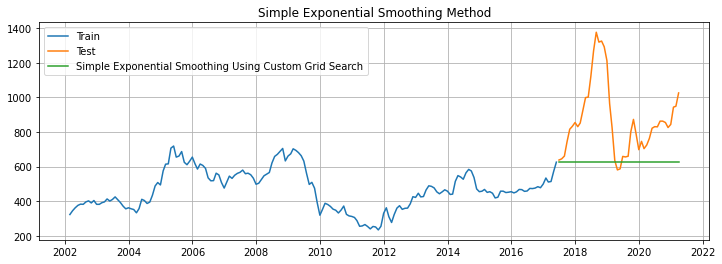

In [145]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot(df_training.TimeIndex, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.TimeIndex, df_test.cpo_pri,  label = 'Test')
plt.plot(df_test.TimeIndex, fcst_auto_pred,label = 'Simple Exponential Smoothing Using Custom Grid Search')
plt.legend(loc = 'best')
#plt.title('Original data after split')
plt.title('Simple Exponential Smoothing Method')
plt.show()

####SES Prediction Plot Zoomed-In

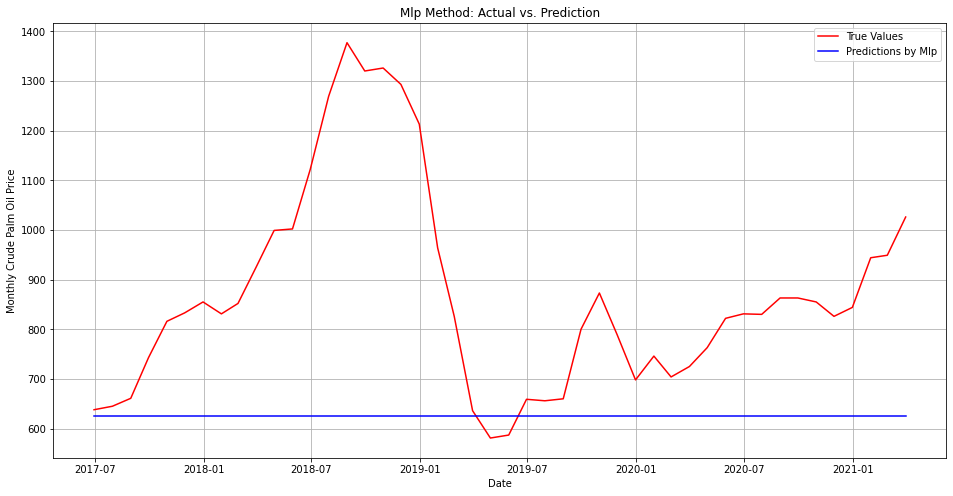

In [167]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.TimeIndex, df_test.cpo_pri, color = 'red',  label = 'Test')
plt.plot(df_test.TimeIndex,  fcst_auto_pred, color = 'blue',label = 'SES Prediction')
plt.legend(['True Values', 'Predictions by SES', 'SES Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###Double Exponential Smoothing (DES)

In [146]:
param_grid = {'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damped' : [True, False]}
pg = list(ParameterGrid(param_grid))

In [147]:
df_results_moni = pd.DataFrame(columns=['smoothing_level', 'smoothing_slope', 'damping_slope','damped','RMSE','r2'])
start = timer()
for a,b in enumerate(pg):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    print(smoothing_level, smoothing_slope, damping_slope,damped)
    fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope = damping_slope ,optimized=False)
    #fit1.summary
    z = fit1.forecast(46)
    print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))}')
    df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Streaming output truncated to the last 5000 lines.
 RMSE is 968.763870195209
0.7 0.7 0.8 False
184     660.246938
185     707.916560
186     755.586181
187     803.255803
188     850.925425
189     898.595046
190     946.264668
191     993.934289
192    1041.603911
193    1089.273532
194    1136.943154
195    1184.612776
196    1232.282397
197    1279.952019
198    1327.621640
199    1375.291262
200    1422.960884
201    1470.630505
202    1518.300127
203    1565.969748
204    1613.639370
205    1661.308992
206    1708.978613
207    1756.648235
208    1804.317856
209    1851.987478
210    1899.657100
211    1947.326721
212    1994.996343
213    2042.665964
214    2090.335586
215    2138.005207
216    2185.674829
217    2233.344451
218    2281.014072
219    2328.683694
220    2376.353315
221    2424.022937
222    2471.692559
223    2519.362180
224    2567.031802
225    2614.701423
226    2662.371045
227    2710.040667
228    2757.710288
229    2805.379910
dtype: float64
 RMSE is 1099.40

In [148]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


,smoothing_level,smoothing_slope,damping_slope,damped,RMSE,r2
647,0.9,0.9,0.8,True,202.367935,0.018329


In [151]:
fit1 = Holt(train,damped =False ).fit(smoothing_level=0.9, smoothing_slope=0.8, damping_slope = 0.8 ,optimized=False)

In [199]:
Forecast_custom_pred = fit1.forecast(46)

In [184]:
fit1.summary()

Dep. Variable:,endog,No. Observations:,184
Model:,Holt,SSE,210173.606
Optimized:,False,AIC,1303.499
Trend:,Additive,BIC,1316.358
Seasonal:,None,AICC,1303.973
Seasonal Periods:,None,Date:,"Sat, 13 Nov 2021"
Box-Cox:,False,Time:,02:04:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9000000,alpha,False
smoothing_slope,0.8000000,beta,False


In [200]:
 Forecast_custom_pred.head()

184    678.938516
185    733.780318
186    788.622120
187    843.463922
188    898.305724
dtype: float64

In [206]:
Forecast_custom_pred  = pd.DataFrame(Forecast_custom_pred, columns = ['Predictions'])

In [207]:
Forecast_custom_pred.head()

,Predictions
184,678.938516
185,733.780318
186,788.622120
187,843.463922
188,898.305724


####Compute SES Evaluation Metrics

In [173]:
test.head()

,Predictions
0,638
1,645
2,661
3,743
4,816


In [174]:
Forecast_custom_pred.head()

,Predictions
184,678.938516
185,733.780318
186,788.622120
187,843.463922
188,898.305724


In [212]:
Forecast_custom_pred.index = pd.RangeIndex(start=0, stop=46, step=1)

In [213]:
Forecast_custom_pred

,Predictions
0,678.938516
1,733.780318
2,788.622120
3,843.463922
4,898.305724
5,953.147526
6,1007.989328
7,1062.831130
8,1117.672932
9,1172.514734


In [214]:
Forecast_custom_pred 

,Predictions
0,678.938516
1,733.780318
2,788.622120
3,843.463922
4,898.305724
5,953.147526
6,1007.989328
7,1062.831130
8,1117.672932
9,1172.514734


####Compute DES Evaluation Metrics

In [215]:
MAE_ses = mean_absolute_error(test,  Forecast_custom_pred)
print('MAE value of the SES Model is:', MAE_ses)

MDA_ses = mda(test,  Forecast_custom_pred)
print("MDA value of the SES Model is:", *MDA_ses)

MAPE_ses = mean_absolute_percentage_error(test,  Forecast_custom_pred)
print('MAPE value of the SES Model is:', MAPE_ses)

RMSE_ses = mean_squared_error(test,  Forecast_custom_pred, squared=False)
print('RMSE value of the SES Model is:', RMSE_ses)

MSE_ses = mean_squared_error(test,  Forecast_custom_pred)
print('MSE value of the SES Model is:', MSE_ses)

MAE value of the SES Model is: 1042.4225397739488
MDA value of the SES Model is: 0.9565217391304348
MAPE value of the SES Model is: 130.89836945855646
RMSE value of the SES Model is: 1297.956247468447
MSE value of the SES Model is: 1684690.4203423723


####Plot train, test and forecast

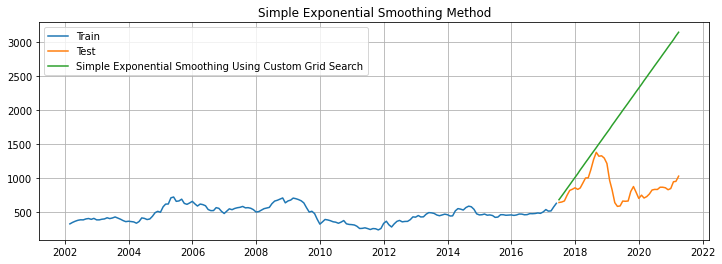

In [216]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot(df_training.TimeIndex, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.TimeIndex, df_test.cpo_pri,  label = 'Test')
plt.plot(df_test.TimeIndex, Forecast_custom_pred,label = 'Simple Exponential Smoothing Using Custom Grid Search')
plt.legend(loc = 'best')
#plt.title('Original data after split')
plt.title('Simple Exponential Smoothing Method')
plt.show()

####DES Prediction Plot Zoomed-In

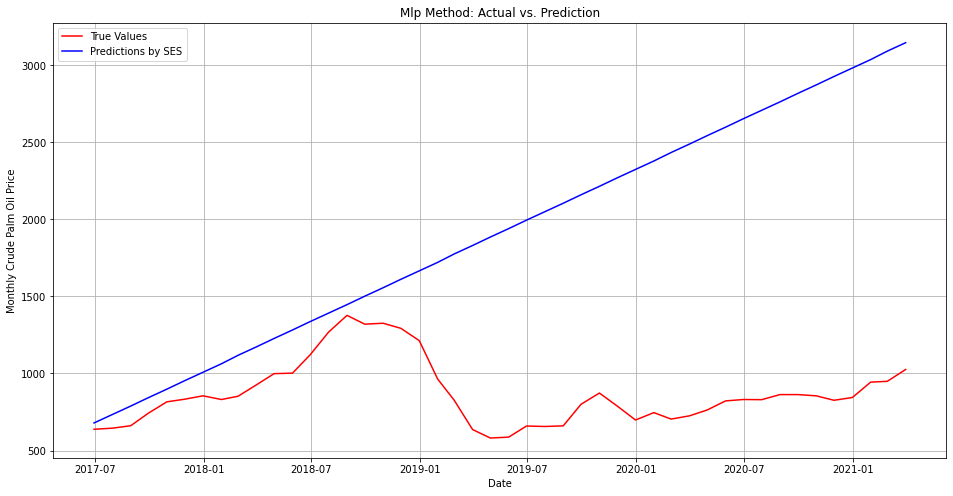

In [217]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.TimeIndex, df_test.cpo_pri, color = 'red',  label = 'Test')
plt.plot(df_test.TimeIndex,  Forecast_custom_pred, color = 'blue',label = 'SES Prediction')
plt.legend(['True Values', 'Predictions by SES', 'SES Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###Triple Exponential Smoothing (TES)

In [138]:
from sklearn.model_selection import ParameterGrid
param_grid = {'trend': ['add', 'mul'],'seasonal' :['add', 'mul'],'seasonal_periods':[3,6,12], 'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damped' : [True, False], 'use_boxcox':[True, False],
             'remove_bias':[True, False],'use_basinhopping':[True, False]}
pg = list(ParameterGrid(param_grid))

In [144]:
df_results_moni = pd.DataFrame(columns=['trend','seasonal_periods','smoothing_level', 'smoothing_slope',
                                        'damping_slope','damped','use_boxcox','remove_bias','use_basinhopping','RMSE','r2'])
start = timer()
print('Starting Grid Search..')
for a,b in enumerate(pg):
    trend = b.get('trend')
    smoothing_level = b.get('smoothing_level')
    seasonal_periods = b.get('seasonal_periods')
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    use_boxcox = b.get('use_boxcox')
    remove_bias = b.get('remove_bias')
    use_basinhopping = b.get('use_basinhopping')
    fit1 = ExponentialSmoothing(train,trend=trend, damped=damped,seasonal_periods=seasonal_periods ).fit(smoothing_level=smoothing_level, 
                                    smoothing_slope=smoothing_slope, damping_slope = damping_slope,use_boxcox=use_boxcox,optimized=False)
    #fit1.summary
    z = fit1.forecast(46)
    #print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    df_results_moni = df_results_moni.append({'trend':trend,'seasonal_periods':seasonal_periods,'smoothing_level':smoothing_level, 'smoothing_slope':smoothing_slope,
                                        'damping_slope':damping_slope,'damped':damped,'use_boxcox':use_boxcox,'use_basinhopping':use_basinhopping,'RMSE':RMSE,'r2':r2}, ignore_index=True)
print('End of Grid Search')
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Starting Grid Search..
End of Grid Search
 Total time taken to complete grid search in seconds: 4759.644579104


In [145]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


,trend,seasonal_periods,smoothing_level,smoothing_slope,damping_slope,damped,use_boxcox,remove_bias,use_basinhopping,RMSE,r2
55068,mul,3,0.9,0.8,0.8,True,True,NaN,True,197.742161,0.062695


In [153]:
fit1 = ExponentialSmoothing(train,trend='mul', damped=False,seasonal_periods=3 ).fit(smoothing_level=0.9,smoothing_slope=0.8, damping_slope = 0.8,use_boxcox=False,use_basinhopping = True,optimized=False)
Forecast_custom_pred = fit1.forecast(46)
fit1.summary()
timeseries_evaluation_metrics_func(test,Forecast_custom_pred)

Evaluation metric results:-
MSE is : 271071688.8023302
MAE is : 10543.547471018557
RMSE is : 16464.254881479763
MAPE is : 1254.5214291498287
R2 is : -6496.805369059765



In [219]:
fitESAUTO = ExponentialSmoothing(train).fit(optimized= True, use_brute = True)
fitESAUTO.summary()

Dep. Variable:,endog,No. Observations:,184
Model:,ExponentialSmoothing,SSE,151479.000
Optimized:,True,AIC,1239.241
Trend:,None,BIC,1245.671
Seasonal:,None,AICC,1239.465
Seasonal Periods:,None,Date:,"Sat, 13 Nov 2021"
Box-Cox:,False,Time:,03:14:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,323.00000,l.0,True


In [220]:
fitESAUTOpred = fitESAUTO.forecast(46)

####Compute TES Evaluation Metrics

In [223]:
MAE_ses = mean_absolute_error(test,  fitESAUTOpred )
print('MAE value of the SES Model is:', MAE_ses)

MDA_ses = mda(test,  fitESAUTOpred )
print("MDA value of the SES Model is:", *MDA_ses)

MAPE_ses = mean_absolute_percentage_error(test,  fitESAUTOpred )
print('MAPE value of the SES Model is:', MAPE_ses)

RMSE_ses = mean_squared_error(test,  fitESAUTOpred, squared=False)
print('RMSE value of the SES Model is:', RMSE_ses)

MSE_ses = mean_squared_error(test,  fitESAUTOpred )
print('MSE value of the SES Model is:', MSE_ses)

MAE value of the SES Model is: 248.1086956521739
MDA value of the SES Model is: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
MAPE value of the SES Model is: 25.11552432741552
RMSE value of the SES Model is: 318.5536266368321
MSE value of the SES Model is: 101476.41304347826


####Plot train, test and forecast

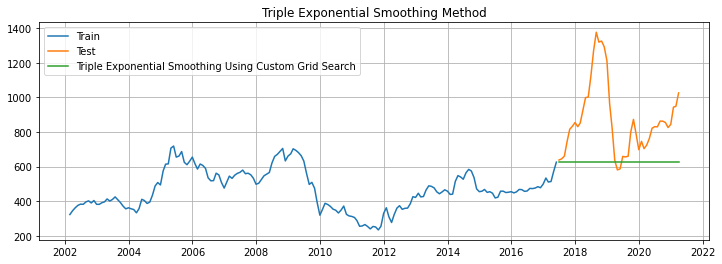

In [225]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot(df_training.TimeIndex, df_training.cpo_pri, label = 'Train')
plt.plot(df_test.TimeIndex, df_test.cpo_pri,  label = 'Test')
plt.plot(df_test.TimeIndex, fitESAUTOpred,label = 'Triple Exponential Smoothing Using Custom Grid Search')
plt.legend(loc = 'best')
plt.title('Triple Exponential Smoothing Method')
plt.show()

####TES Prediction Plot Zoomed-In

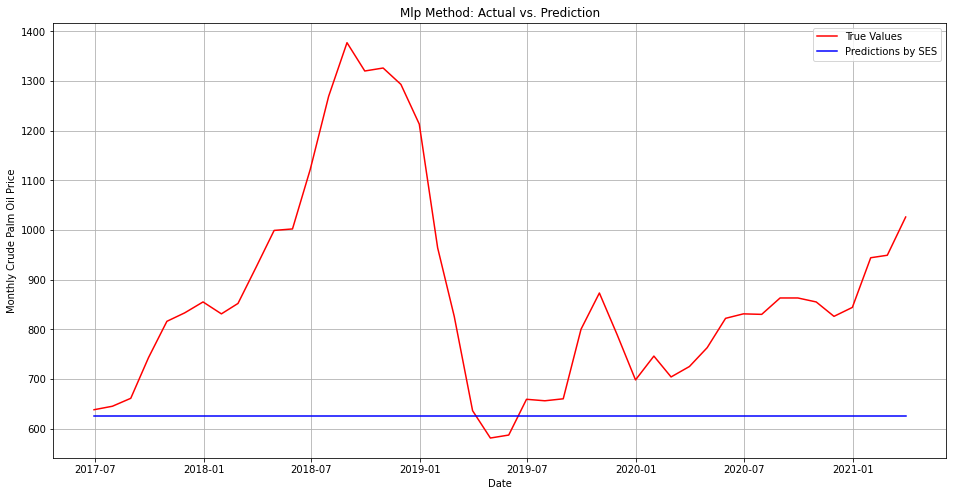

In [226]:
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(df_test.TimeIndex, df_test.cpo_pri, color = 'red',  label = 'Test')
plt.plot(df_test.TimeIndex,  fitESAUTOpred, color = 'blue',label = 'SES Prediction')
plt.legend(['True Values', 'Predictions by SES', 'SES Prediction'],loc='best')
plt.title('Mlp Method: Actual vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

###Inference
Based on the RMSE score the best model is the Triple Exponential Smoothing Method